## Movie Recommendation System


### Creating a Recommender System to suggest personalized movie recommendations on the basis of ratings given by a different users and Finding the similar user to improve overall user experience.

### Importing Data and libraries

In [118]:
# zee-users.dat
!gdown 1-xsSNizet0ruiMgKLWRcmme8L_iDejhc

# zee-ratings.dat
!gdown 1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk

# zee-movies.dat
!gdown 15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ

Downloading...
From: https://drive.google.com/uc?id=1-xsSNizet0ruiMgKLWRcmme8L_iDejhc
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 84.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XJpSzv-UMeSmCCOdyZviRF4XCxiKJUrk
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 35.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=15QeQgmjoeBxRDEOFPSrMr8eIvwk6QgUQ
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 81.3MB/s]


In [119]:
# !pip install cmfrec skimpy

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

from cmfrec import CMF
from skimpy import clean_columns
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import (
    mean_absolute_error as mae,
    mean_squared_error as mse,
    mean_absolute_percentage_error as mape
)

In [121]:
ratings = pd.read_csv('./zee-ratings.dat', delimiter = '::', encoding='ISO-8859-1')
users = pd.read_csv('./zee-users.dat', delimiter = '::', encoding='ISO-8859-1')
movies = pd.read_csv('./zee-movies.dat', delimiter = '::', encoding='ISO-8859-1')

### Exploratory Data Analysis

In [122]:
ratings.shape

(1000209, 4)

In [123]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [124]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [125]:
ratings.describe()

,UserID,MovieID,Rating,Timestamp
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


In [126]:
print(f'Unique User Count in Ratings: {len(ratings.UserID.drop_duplicates())}')
print(f'Unique Movie Count in Ratings: {len(ratings.MovieID.drop_duplicates())}')
print(f'Unique Rating Count in Ratings: {len(ratings.Rating.drop_duplicates())}')
print(ratings.Rating.value_counts(normalize = True).sort_index().mul(100).round(2).astype('str')+'%')

Unique User Count in Ratings: 6040
Unique Movie Count in Ratings: 3706
Unique Rating Count in Ratings: 5
Rating
1     5.62%
2    10.75%
3    26.11%
4    34.89%
5    22.63%
Name: proportion, dtype: object


In [127]:
ratings.duplicated().sum()

0

In [128]:
ratings.isna().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

<Axes: >

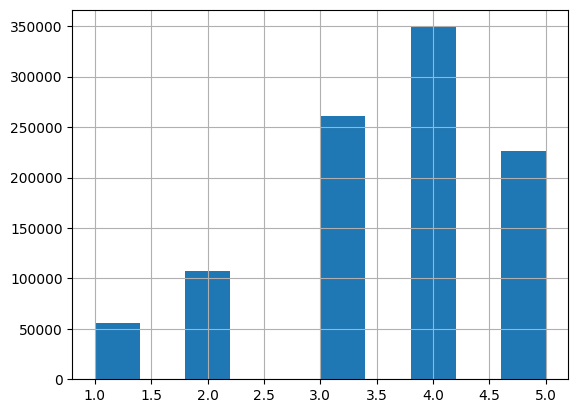

In [129]:
ratings.Rating.hist()

In [130]:
pd.to_datetime(ratings['Timestamp'])

0         1970-01-01 00:00:00.978300760
1         1970-01-01 00:00:00.978302109
2         1970-01-01 00:00:00.978301968
3         1970-01-01 00:00:00.978300275
4         1970-01-01 00:00:00.978824291
                       ...             
1000204   1970-01-01 00:00:00.956716541
1000205   1970-01-01 00:00:00.956704887
1000206   1970-01-01 00:00:00.956704746
1000207   1970-01-01 00:00:00.956715648
1000208   1970-01-01 00:00:00.956715569
Name: Timestamp, Length: 1000209, dtype: datetime64[ns]

In [131]:
users.shape

(6040, 5)

In [132]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [133]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [134]:
users.describe(include = 'all')

,UserID,Gender,Age,Occupation,Zip-code
count,6040.000000,6040,6040.000000,6040.000000,6040
unique,NaN,2,NaN,NaN,3439
top,NaN,M,NaN,NaN,48104
freq,NaN,4331,NaN,NaN,19
mean,3020.500000,NaN,30.639238,8.146854,NaN
std,1743.742145,NaN,12.895962,6.329511,NaN
min,1.000000,NaN,1.000000,0.000000,NaN
25%,1510.750000,NaN,25.000000,3.000000,NaN
50%,3020.500000,NaN,25.000000,7.000000,NaN
75%,4530.250000,NaN,35.000000,14.000000,NaN


<Axes: >

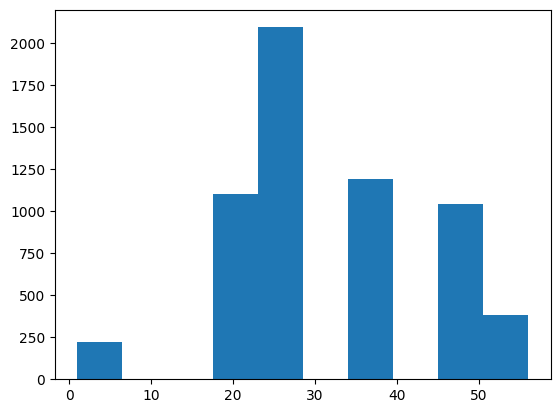

In [135]:
users.Age.hist(grid=False)

In [136]:
print(f'Unique user ID Count in users: {len(users.UserID.drop_duplicates())}')

Unique user ID Count in users: 6040


In [137]:
users.UserID.duplicated().sum()

0

In [138]:
users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [139]:
movies.shape

(3883, 3)

In [140]:
movies.head()

,Movie ID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [141]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Movie ID  3883 non-null   int64 
 1   Title     3883 non-null   object
 2   Genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [142]:
movies.describe(include = 'all')

,Movie ID,Title,Genres
count,3883.000000,3883,3883
unique,NaN,3883,301
top,NaN,Toy Story (1995),Drama
freq,NaN,1,843
mean,1986.049446,NaN,NaN
std,1146.778349,NaN,NaN
min,1.000000,NaN,NaN
25%,982.500000,NaN,NaN
50%,2010.000000,NaN,NaN
75%,2980.500000,NaN,NaN


In [143]:
print(f'Unique Movie Count in movies: {len(movies["Movie ID"].drop_duplicates())}')

Unique Movie Count in movies: 3883


In [144]:
movies.duplicated().sum()

0

In [145]:
movies.isna().sum()

Movie ID    0
Title       0
Genres      0
dtype: int64

### Feature Engineering

In [146]:
ratings = clean_columns(ratings, case = 'snake')
users = clean_columns(users, case = 'snake')
movies = clean_columns(movies, case = 'snake')

In [147]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [148]:
users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [149]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [150]:
movies['movie_yr'] = movies['title'].str.extract('(\d{4})').astype('int32')

In [151]:
movies.head()

,movie_id,title,genres,movie_yr
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [152]:
movies['movie_yr'].apply(['min', 'max'])

min    1600
max    9000
Name: movie_yr, dtype: int32

In [153]:
movies['movie_yr'].value_counts().sort_index()

movie_yr
1600    1
1900    1
1919    3
1920    2
1921    1
       ..
2001    1
2010    1
3000    1
8230    1
9000    1
Name: count, Length: 88, dtype: int64

<Axes: >

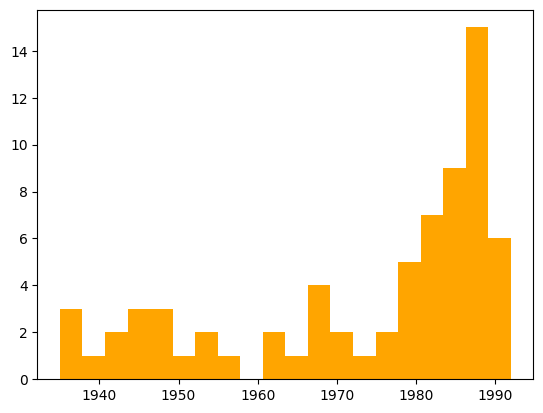

In [154]:
movies[(movies['movie_id']> 1930) & (movies['movie_id'] <= 2000)]['movie_yr'].hist(bins = 20, grid = False, color = 'orange')

In [155]:
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
ratings['hour'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [156]:
ratings.head()

,user_id,movie_id,rating,timestamp,date,hour
0,1,1193,5,978300760,2000-12-31,22
1,1,661,3,978302109,2000-12-31,22
2,1,914,3,978301968,2000-12-31,22
3,1,3408,4,978300275,2000-12-31,22
4,1,2355,5,978824291,2001-01-06,23


In [157]:
# movies.head()

In [158]:
movies_copy = movies.copy()
movies_copy['genres'] = movies_copy['genres'].str.split('|')
movies_copy = movies_copy.explode('genres')
movies_copy.head()

,movie_id,title,genres,movie_yr
0,1,Toy Story (1995),Animation,1995
0,1,Toy Story (1995),Children's,1995
0,1,Toy Story (1995),Comedy,1995
1,2,Jumanji (1995),Adventure,1995
1,2,Jumanji (1995),Children's,1995


In [159]:
df_zee = ratings.merge(right = users, how = 'left', on = 'user_id')
df_zee = df_zee.merge(right = movies, how = 'left', on = 'movie_id')
df_zee['title'] = df_zee['title'].apply(lambda x: re.sub(r'( \(\d+\))', '', x))

In [160]:
df_zee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   user_id     1000209 non-null  int64 
 1   movie_id    1000209 non-null  int64 
 2   rating      1000209 non-null  int64 
 3   timestamp   1000209 non-null  int64 
 4   date        1000209 non-null  object
 5   hour        1000209 non-null  int64 
 6   gender      1000209 non-null  object
 7   age         1000209 non-null  int64 
 8   occupation  1000209 non-null  int64 
 9   zip_code    1000209 non-null  object
 10  title       1000209 non-null  object
 11  genres      1000209 non-null  object
 12  movie_yr    1000209 non-null  int32 
dtypes: int32(1), int64(7), object(5)
memory usage: 95.4+ MB


In [161]:
df_zee.head()

,user_id,movie_id,rating,timestamp,date,hour,gender,age,occupation,zip_code,title,genres,movie_yr
0,1,1193,5,978300760,2000-12-31,22,F,1,10,48067,One Flew Over the Cuckoo's Nest,Drama,1975
1,1,661,3,978302109,2000-12-31,22,F,1,10,48067,James and the Giant Peach,Animation|Children's|Musical,1996
2,1,914,3,978301968,2000-12-31,22,F,1,10,48067,My Fair Lady,Musical|Romance,1964
3,1,3408,4,978300275,2000-12-31,22,F,1,10,48067,Erin Brockovich,Drama,2000
4,1,2355,5,978824291,2001-01-06,23,F,1,10,48067,"Bug's Life, A",Animation|Children's|Comedy,1998


In [162]:
df_zee.duplicated().sum()

0

In [163]:
df_zee['movie_yr'].quantile(.01), df_zee['movie_yr'].quantile(.99)

(1938.0, 2000.0)

In [164]:
df_zee = df_zee[df_zee['movie_yr'].between(left = df_zee['movie_yr'].quantile(.01), right = df_zee['movie_yr'].quantile(.99), inclusive = 'both')]
df_zee.info()

<class 'pandas.core.frame.DataFrame'>
Index: 987828 entries, 0 to 1000208
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_id     987828 non-null  int64 
 1   movie_id    987828 non-null  int64 
 2   rating      987828 non-null  int64 
 3   timestamp   987828 non-null  int64 
 4   date        987828 non-null  object
 5   hour        987828 non-null  int64 
 6   gender      987828 non-null  object
 7   age         987828 non-null  int64 
 8   occupation  987828 non-null  int64 
 9   zip_code    987828 non-null  object
 10  title       987828 non-null  object
 11  genres      987828 non-null  object
 12  movie_yr    987828 non-null  int32 
dtypes: int32(1), int64(7), object(5)
memory usage: 101.7+ MB


In [165]:
df_zee_pivot = df_zee.sample(700000).groupby(['user_id', 'title'])['movie_id'].sum().unstack().fillna(0)
df_zee_pivot = (df_zee_pivot>0).astype('int')

In [166]:
df_zee_pivot.shape

(6040, 3540)

In [167]:
df_zee_pivot.head()

title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",187,...,Young Guns II,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

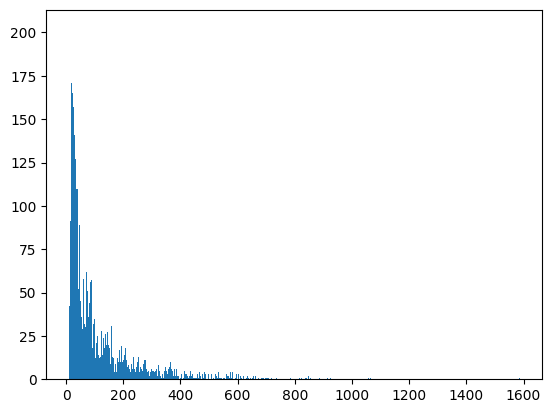

In [168]:
df_zee_pivot.sum(axis = 1).hist(bins=1000, grid = False)

In [169]:
df_zee_pivot.sum(axis = 1).quantile(.1)

19.0

In [170]:
pd.DataFrame(df_zee_pivot.loc[799, df_zee_pivot.loc[799] == 1])

,799
title,
28 Days,1
8 1/2 Women,1
Agnes Browne,1
American Psycho,1
Any Given Sunday,1
"Big Kahuna, The",1
Black and White,1
But I'm a Cheerleader,1
"City of Lost Children, The",1


### Implementation of APRIORI algorithm

In [171]:
df_movieset = apriori(df_zee_pivot, min_support=0.1, use_colnames = True).sort_values('support', ascending = False)

In [172]:
df_movieset.shape

(788, 2)

In [173]:
df_movieset.head()

,support,itemsets
10,0.400993,(American Beauty)
237,0.355464,(Star Wars: Episode IV - A New Hope)
238,0.350331,(Star Wars: Episode V - The Empire Strikes Back)
239,0.333940,(Star Wars: Episode VI - Return of the Jedi)
140,0.310430,(Jurassic Park)


In [174]:
df_movieset.loc[df_movieset['itemsets'].apply(lambda x: len(x)) >= 2]

,support,itemsets
759,0.200828,(Star Wars: Episode V - The Empire Strikes Bac...
768,0.179305,"(Star Wars: Episode VI - Return of the Jedi, S..."
760,0.176821,"(Star Wars: Episode VI - Return of the Jedi, S..."
690,0.168543,"(Raiders of the Lost Ark, Star Wars: Episode I..."
637,0.164404,"(Matrix, The, Terminator 2: Judgment Day)"
...,...,...
733,0.100000,"(Usual Suspects, The, Shawshank Redemption, The)"
386,0.100000,"(Batman, Raiders of the Lost Ark)"
449,0.100000,"(Face/Off, Men in Black)"
664,0.100000,"(Star Wars: Episode I - The Phantom Menace, Pr..."


In [175]:
df_movierules = association_rules(df_movieset, metric = 'lift', min_threshold = 1)

In [176]:
df_movierules.shape

(1022, 10)

In [177]:
df_movierules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Star Wars: Episode V - The Empire Strikes Back),(Star Wars: Episode IV - A New Hope),0.350331,0.355464,0.200828,0.573251,1.612687,0.076298,1.510342,0.584785
1,(Star Wars: Episode IV - A New Hope),(Star Wars: Episode V - The Empire Strikes Back),0.355464,0.350331,0.200828,0.564974,1.612687,0.076298,1.493404,0.589442
2,(Star Wars: Episode VI - Return of the Jedi),(Star Wars: Episode V - The Empire Strikes Back),0.333940,0.350331,0.179305,0.536936,1.532653,0.062315,1.402979,0.521780
3,(Star Wars: Episode V - The Empire Strikes Back),(Star Wars: Episode VI - Return of the Jedi),0.350331,0.333940,0.179305,0.511815,1.532653,0.062315,1.364358,0.534944
4,(Star Wars: Episode VI - Return of the Jedi),(Star Wars: Episode IV - A New Hope),0.333940,0.355464,0.176821,0.529499,1.489602,0.058118,1.369895,0.493469


In [178]:
df_movierules['lift'].sort_values(ascending = False)[:5].tolist()

[2.3445384675102865,
 2.3445384675102865,
 2.328047619345255,
 2.328047619345255,
 2.3223309503287197]

In [179]:
topN = 10
df_movierules[df_movierules['lift'].isin(df_movierules['lift'].sort_values(ascending = False)[:topN].tolist())].sort_values(by ='lift', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
802,"(Hunt for Red October, The)","(Fugitive, The)",0.193874,0.229470,0.104305,0.538002,2.344538,0.059816,1.667820,0.711399
803,"(Fugitive, The)","(Hunt for Red October, The)",0.229470,0.193874,0.104305,0.454545,2.344538,0.059816,1.477897,0.744263
290,"(Godfather: Part II, The)","(Godfather, The)",0.200166,0.262914,0.122517,0.612076,2.328048,0.069890,1.900079,0.713217
291,"(Godfather, The)","(Godfather: Part II, The)",0.262914,0.200166,0.122517,0.465995,2.328048,0.069890,1.497803,0.773933
323,(Aliens),(Alien),0.215894,0.240397,0.120530,0.558282,2.322331,0.068629,1.719656,0.726175
322,(Alien),(Aliens),0.240397,0.215894,0.120530,0.501377,2.322331,0.068629,1.572544,0.749600
566,(Die Hard),"(Terminator, The)",0.199669,0.242881,0.110596,0.553897,2.280531,0.062100,1.697185,0.701592
567,"(Terminator, The)",(Die Hard),0.242881,0.199669,0.110596,0.455351,2.280531,0.062100,1.469444,0.741634
340,(Aliens),"(Terminator, The)",0.215894,0.242881,0.119205,0.552147,2.273326,0.066769,1.690554,0.714337
341,"(Terminator, The)",(Aliens),0.242881,0.215894,0.119205,0.490798,2.273326,0.066769,1.539871,0.739799


In [180]:
df_movierules[df_movierules.index == 824]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
824,(Toy Story),"(Silence of the Lambs, The)",0.244371,0.307947,0.104139,0.426152,1.383848,0.028886,1.205986,0.367081


In [181]:
df_movierules[df_movierules['antecedents'] == {'Speed'}].sort_values(by = 'lift', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
650,(Speed),"(Matrix, The)",0.19851,0.302483,0.108113,0.544621,1.800497,0.048067,1.531726,0.554714
714,(Speed),(Jurassic Park),0.19851,0.310430,0.106457,0.536280,1.727537,0.044833,1.487039,0.525448
930,(Speed),(Men in Black),0.19851,0.297020,0.101821,0.512927,1.726913,0.042860,1.443276,0.525187
746,(Speed),(Terminator 2: Judgment Day),0.19851,0.308775,0.105464,0.531276,1.720594,0.044169,1.474696,0.522533
1010,(Speed),(Saving Private Ryan),0.19851,0.309437,0.100166,0.504587,1.630662,0.038739,1.393914,0.482541


### Recommender System on the basis of different similarities

In [182]:
def manhatten_distance(x_series, y_series):
  return round(np.sum(np.abs(x_series - y_series)), 2)

def euclidean_distance(x_series, y_series):
  return round(np.sqrt(np.sum((x_series - y_series) ** 2)), 2)

def cosine_distance(x_series, y_series):
  return 1 - round(np.dot(x_series, y_series)/ (np.linalg.norm(x_series) * np.linalg.norm(y_series)), 2)

def pearson_coeff(x_series, y_series):
  return pearsonr(x_series, y_series)[0]

In [183]:
def recSys_similarity(df, q_factor, distance_metric, topN = 10):
  distance_score = []
  for entity in df.index.tolist():
    if q_factor == entity:
      pass
    else:
      distance_score.append([q_factor, entity, distance_metric(df.loc[q_factor], df.loc[entity])])

  if distance_metric == pearson_coeff:
    distance_score = sorted(distance_score, key= lambda x: x[2], reverse = True)[:topN]
  else:
    distance_score = sorted(distance_score, key= lambda x: x[2], reverse = False)[:topN]
  return distance_score


In [184]:
# df_zee_pivot[df_zee_pivot.index == 200]

In [185]:
manhatten_distance(df_zee_pivot.loc[200], df_zee_pivot.loc[205])

116

In [186]:
euclidean_distance(df_zee_pivot.loc[200], df_zee_pivot.loc[205])

10.77

In [187]:
cosine_distance(df_zee_pivot.loc[200], df_zee_pivot.loc[205])

0.9299999999999999

In [188]:
pearson_coeff(df_zee_pivot.loc[200], df_zee_pivot.loc[205])

0.056292446399439075

#### User - User similarity

In [189]:
df_zee_pivot.head()

title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",187,...,Young Guns II,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
df_zee_pivot.shape

(6040, 3540)

In [191]:
recSys_similarity(df_zee_pivot[:20], 10, cosine_distance)

[[10, 19, 0.75],
 [10, 18, 0.77],
 [10, 17, 0.8],
 [10, 13, 0.81],
 [10, 3, 0.8200000000000001],
 [10, 9, 0.84],
 [10, 15, 0.85],
 [10, 1, 0.86],
 [10, 11, 0.86],
 [10, 2, 0.87]]

In [192]:
recSys_similarity(df_zee_pivot[:20], 10, manhatten_distance, topN = 5)

[[10, 3, 275], [10, 4, 277], [10, 12, 279], [10, 20, 282], [10, 1, 283]]

In [193]:
recSys_similarity(df_zee_pivot[:20], 10, pearson_coeff, topN = 5)

[[10, 19, 0.2017267946175112],
 [10, 18, 0.16938593605651425],
 [10, 3, 0.1626179163069026],
 [10, 13, 0.15427786321376613],
 [10, 17, 0.152277401593628]]

In [194]:
def recSys_user_similarity(user_id, similarity_metric, topN = 3):
  if similarity_metric == 'manhatten':
    near_neighbour = recSys_similarity(df_zee_pivot[:2000], user_id, manhatten_distance, topN)
  elif similarity_metric == 'euclidean':
    near_neighbour = recSys_similarity(df_zee_pivot[:2000], user_id, euclidean_distance, topN)
  elif similarity_metric == 'cosine':
    near_neighbour = recSys_similarity(df_zee_pivot[:2000], user_id, cosine_distance, topN)
  elif similarity_metric == 'pearson':
    near_neighbour = recSys_similarity(df_zee_pivot[:2000], user_id, pearson_coeff, topN)
  else:
    print('Wrong Similarity Metric')
    return None

  rec_movies = set()
  for candidate in [x[1] for x in near_neighbour]:
    rec_movies.update(df_zee_pivot.loc[candidate, df_zee_pivot.loc[candidate] == 1].index.tolist())
    # print([movie for movie in df_zee_pivot.loc[candidate, df_zee_pivot.loc[candidate] == 1].index.tolist()])

  rec_movies_list = []
  for movie in rec_movies:
    if movie in df_zee_pivot.loc[user_id, df_zee_pivot.loc[user_id] == 1].index.tolist():
      pass
    else:
      rec_movies_list.append(movie)

  return rec_movies_list

In [195]:
recSys_user_similarity(user_id = 10, similarity_metric = 'cosine')

['Hero',
 'Fast Times at Ridgemont High',
 'Lady and the Tramp',
 "On Her Majesty's Secret Service",
 'Stop! Or My Mom Will Shoot',
 'Evil Dead II (Dead By Dawn)',
 'Spartacus',
 'Mask of Zorro, The',
 'Tales from the Darkside: The Movie',
 'Enemy of the State',
 'Run Lola Run (Lola rennt)',
 'Young Sherlock Holmes',
 'Teenage Mutant Ninja Turtles',
 'Taxi Driver',
 'Who Framed Roger Rabbit?',
 'Seven Years in Tibet',
 'Encino Man',
 'I Still Know What You Did Last Summer',
 'In the Heat of the Night',
 'Forget Paris',
 'Saving Grace',
 'Rush Hour',
 'Teenage Mutant Ninja Turtles III',
 'Drop Dead Fred',
 'Little Big Man',
 'Distinguished Gentleman, The',
 'Short Cuts',
 'Primary Colors',
 'D2: The Mighty Ducks',
 'Mixed Nuts',
 'Die Hard 2',
 'Elephant Man, The',
 'What Lies Beneath',
 "Who's Harry Crumb?",
 'Wild Wild West',
 'Muppets Take Manhattan, The',
 'Doctor Zhivago',
 'Fletch',
 'Sound of Music, The',
 'Few Good Men, A',
 'Freaky Friday',
 'Bean',
 'Misérables, Les',
 'Threes

In [196]:
recSys_user_similarity(user_id = 10, similarity_metric = 'pearson')

['Hero',
 'Fast Times at Ridgemont High',
 'Lady and the Tramp',
 "On Her Majesty's Secret Service",
 'Evil Dead II (Dead By Dawn)',
 'Jaws 2',
 'Spartacus',
 'Mask of Zorro, The',
 'Enemy of the State',
 'Young Sherlock Holmes',
 'Teenage Mutant Ninja Turtles',
 'Taxi Driver',
 'Who Framed Roger Rabbit?',
 'Seven Years in Tibet',
 'Dangerous Liaisons',
 'Encino Man',
 'I Still Know What You Did Last Summer',
 'In the Heat of the Night',
 'Forget Paris',
 'Saving Grace',
 'Rush Hour',
 'Teenage Mutant Ninja Turtles III',
 'Drop Dead Fred',
 'Little Big Man',
 'Short Cuts',
 'Primary Colors',
 'D2: The Mighty Ducks',
 'Mixed Nuts',
 'Die Hard 2',
 'Elephant Man, The',
 "Who's Harry Crumb?",
 'Wild Wild West',
 'Doctor Zhivago',
 'Fletch',
 'Sound of Music, The',
 'Few Good Men, A',
 'Freaky Friday',
 'Bean',
 'Misérables, Les',
 'Double Indemnity',
 'Arthur',
 'Austin Powers: The Spy Who Shagged Me',
 'History of the World: Part I',
 'Secret of NIMH, The',
 'Marathon Man',
 'Wizard of O

### Matrix Factorization

In [197]:
ratings.head()

,user_id,movie_id,rating,timestamp,date,hour
0,1,1193,5,978300760,2000-12-31,22
1,1,661,3,978302109,2000-12-31,22
2,1,914,3,978301968,2000-12-31,22
3,1,3408,4,978300275,2000-12-31,22
4,1,2355,5,978824291,2001-01-06,23


In [198]:
rm_raw = ratings[['user_id', 'movie_id', 'rating']].copy()
rm_raw.columns = ['UserId', 'ItemId', 'Rating']
rm_raw.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [199]:
model = CMF(k=3, lambda_= 0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm_raw)

Collective matrix factorization model
(explicit-feedback variant)


In [200]:
model.A_.shape, model.B_.shape

((6040, 3), (3706, 3))

In [201]:
model.A_

array([[-0.00958391, -0.17743202,  0.16195586],
       [-0.16286132, -0.3025382 , -0.37213776],
       [-0.08792485, -0.22111896, -0.04388591],
       ...,
       [-0.14682147, -0.21881038, -0.24433388],
       [-0.17056152, -0.09411836, -0.11553887],
       [-0.3991945 ,  0.24622837, -0.16886806]], dtype=float32)

In [202]:
model.B_

array([[-4.013367  , -1.4335079 ,  1.2978806 ],
       [ 0.27379817, -0.48399982,  2.3520467 ],
       [-1.7438495 , -3.3851151 ,  0.4928088 ],
       ...,
       [ 0.9760184 ,  1.8206757 , -1.9986285 ],
       [-0.37541583, -1.8747995 , -1.0537992 ],
       [-0.6224832 ,  0.10011666,  0.19826597]], dtype=float32)

In [203]:
top_movies = model.topN(user = 10, n = 15)

In [204]:
top_movies
movies.loc[movies['movie_id'].isin (top_movies)]

,movie_id,title,genres,movie_yr
591,595,Beauty and the Beast (1991),Animation|Children's|Musical,1991
633,638,Jack and Sarah (1995),Romance,1995
638,643,Peanuts - Die Bank zahlt alles (1996),Comedy,1996
925,937,Love in the Afternoon (1957),Comedy|Romance,1957
949,961,Little Lord Fauntleroy (1936),Drama,1936
1009,1022,Cinderella (1950),Animation|Children's|Musical,1950
1022,1035,"Sound of Music, The (1965)",Musical,1965
1085,1101,Top Gun (1986),Action|Romance,1986
1144,1160,Six of a Kind (1934),Comedy,1934
1461,1493,Love and Other Catastrophes (1996),Romance,1996


In [205]:
ratings.head()

,user_id,movie_id,rating,timestamp,date,hour
0,1,1193,5,978300760,2000-12-31,22
1,1,661,3,978302109,2000-12-31,22
2,1,914,3,978301968,2000-12-31,22
3,1,3408,4,978300275,2000-12-31,22
4,1,2355,5,978824291,2001-01-06,23


In [206]:
test_actual = ratings.pivot(index = 'user_id', columns = 'movie_id', values = 'rating').fillna(0)
test_actual.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
test_pred = np.dot(model.A_, model.B_.T) + model.glob_mean_
pd.DataFrame(test_pred).head()

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,4.084578,4.045745,4.278718,4.143150,4.142251,4.137294,4.225701,4.147022,4.269500,4.245592,...,4.186228,3.249333,3.659343,3.685873,3.671183,3.619873,3.454109,2.925475,3.747143,3.601877
1,4.185887,2.808116,4.706304,4.301580,3.920882,4.383686,4.490590,4.225545,4.273593,4.597567,...,3.229398,3.775062,3.289245,3.257650,3.594367,3.646678,3.295634,3.615550,4.602062,3.578871
2,4.194456,3.561291,4.461778,4.196271,4.064558,4.282192,4.354314,4.225986,4.273717,4.422960,...,3.808825,3.456696,3.515011,3.508316,3.646727,3.661306,3.383916,3.180874,4.075374,3.605457
3,5.112305,3.262515,4.029944,3.433739,3.717595,4.683981,4.185446,4.635767,3.640505,4.521979,...,3.274292,3.750395,3.497513,3.258381,3.682069,4.250899,3.365537,3.443224,3.665947,3.845068
4,3.947006,2.995790,2.672935,2.510035,2.861670,3.476245,2.934867,3.478420,2.521445,3.139368,...,2.685988,4.073637,3.513402,3.301509,3.542397,4.039001,3.668663,4.297029,3.097764,3.764405


In [208]:
test_actual.shape, test_pred.shape

((6040, 3706), (6040, 3706))

In [209]:
def mf_performance_metric(act, pred):
  print('MAE : {}'.format(mae(act.values[act >= 1], pred[act >= 1])))
  print('RMSE : {}'.format(np.sqrt(mae(act.values[act >= 1], pred[act >= 1]))))
  print('MAPE : {}'.format(mae(act.values[act >= 1], pred[act >= 1])))

In [210]:
mf_performance_metric(test_actual, test_pred)

MAE : 1.064174736285973
RMSE : 1.0315884529626982
MAPE : 1.064174736285973


In [211]:
test_actual[test_actual>1].shape, test_pred[test_actual>1].shape

((6040, 3706), (944035,))

### Movies Recommendation on the basis of Pearson's Correlation (Item - Item based Approach)

In [212]:
movie_rating_genre = ratings.join(other = movies_copy, how = 'left', on = 'movie_id', rsuffix='r').drop('movie_idr', axis = 1)
movie_rating_genre.head()

,user_id,movie_id,rating,timestamp,date,hour,title,genres,movie_yr
0,1,1193,5,978300760,2000-12-31,22,Wings of Desire (Der Himmel über Berlin) (1987),Comedy,1987.0
0,1,1193,5,978300760,2000-12-31,22,Wings of Desire (Der Himmel über Berlin) (1987),Drama,1987.0
0,1,1193,5,978300760,2000-12-31,22,Wings of Desire (Der Himmel über Berlin) (1987),Romance,1987.0
1,1,661,3,978302109,2000-12-31,22,Bloodsport 2 (1995),Action,1995.0
2,1,914,3,978301968,2000-12-31,22,All About Eve (1950),Drama,1950.0


In [213]:
movie_genre_pivot = movie_rating_genre.groupby(['movie_id', 'genres'])['rating'].mean().unstack().T.fillna(0)
movie_genre_pivot.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
genres,,,,,,,,,,,,,,,,,,,,,
Action,0.000000,0.000000,0.000000,0.000000,3.006757,0.000000,0.00000,3.014706,2.656863,0.000000,...,0.000000,0.0,0.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.0
Adventure,4.146846,0.000000,0.000000,0.000000,0.000000,0.000000,3.41048,0.000000,2.656863,0.000000,...,0.000000,0.0,2.8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Animation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,2.8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Children's,4.146846,0.000000,0.000000,0.000000,0.000000,0.000000,3.41048,0.000000,0.000000,0.000000,...,0.000000,0.0,2.8,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Comedy,0.000000,3.201141,3.016736,2.729412,0.000000,3.878723,0.00000,0.000000,0.000000,3.540541,...,3.667857,3.0,0.0,0.0,0.0,2.833333,0.0,0.0,0.0,0.0


In [214]:
movie_genre_pivot.shape

(18, 3637)

In [215]:
movie_genre_pivot.loc[:, 1193]

genres
Action         0.000000
Adventure      0.000000
Animation      0.000000
Children's     0.000000
Comedy         4.390725
Crime          0.000000
Documentary    0.000000
Drama          4.390725
Fantasy        0.000000
Film-Noir      0.000000
Horror         0.000000
Musical        0.000000
Mystery        0.000000
Romance        4.390725
Sci-Fi         0.000000
Thriller       0.000000
War            0.000000
Western        0.000000
Name: 1193, dtype: float64

In [216]:
corr_movie_df = movie_genre_pivot.corr(method = 'pearson')
corr_movie_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3873,3874,3875,3876,3877,3878,3879,3880,3881,3882
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.158114,-0.158114,-0.108465,-0.200000,-0.158114,0.790569,-0.108465,0.200000,-0.200000,...,-0.108465,-0.158114,0.600000,-0.200000,-0.108465,-0.108465,-0.108465,-0.108465,-0.108465,-0.158114
2,-0.158114,1.000000,0.437500,0.685994,-0.158114,1.000000,-0.125000,-0.085749,-0.158114,0.790569,...,0.685994,0.437500,-0.158114,-0.158114,-0.085749,0.685994,-0.085749,-0.085749,-0.085749,-0.125000
3,-0.158114,0.437500,1.000000,0.685994,-0.158114,0.437500,-0.125000,-0.085749,-0.158114,0.790569,...,0.685994,1.000000,-0.158114,0.316228,-0.085749,0.685994,0.685994,0.685994,0.685994,0.437500
4,-0.108465,0.685994,0.685994,1.000000,-0.108465,0.685994,-0.085749,-0.058824,-0.108465,0.542326,...,1.000000,0.685994,-0.108465,-0.108465,-0.058824,1.000000,-0.058824,-0.058824,-0.058824,-0.085749
5,-0.200000,-0.158114,-0.158114,-0.108465,1.000000,-0.158114,-0.158114,0.542326,0.600000,-0.200000,...,-0.108465,-0.158114,-0.200000,0.600000,0.542326,-0.108465,-0.108465,-0.108465,-0.108465,0.316228


In [217]:
corr_movie_df.shape

(3637, 3637)

In [218]:
corr_movie_df[595].sort_values(ascending = False)[:15].index.to_list()

[1365,
 1263,
 3575,
 2853,
 3723,
 1246,
 549,
 3612,
 208,
 3101,
 3296,
 3439,
 379,
 3304,
 412]

In [219]:
# movies[movies['movie_id'].isin(corr_movie_df[595].sort_values(ascending = False)[:15].index.to_list())]

In [220]:
movies.head()

,movie_id,title,genres,movie_yr
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [221]:
def recSys_on_pearson_corr(title, rec_cnt = 10):
  movie_details = movies[movies.title.str.contains(title)].iloc[0]
  movie_title = movie_details['title']
  print(f'Movie Name: {movie_title}')
  movie_id = movie_details['movie_id']

  movie_recSys = movies[movies['movie_id'].isin(corr_movie_df[movie_id].sort_values(ascending = False)[:rec_cnt].index.to_list())]
  return movie_recSys

In [222]:
recSys_on_pearson_corr('Beauty and the')

Movie Name: Beauty and the Beast (1991)


,movie_id,title,genres,movie_yr
206,208,Waterworld (1995),Action|Adventure,1995
545,549,Thirty-Two Short Films About Glenn Gould (1993),Documentary,1993
1226,1246,Dead Poets Society (1989),Drama,1989
1243,1263,"Deer Hunter, The (1978)",Drama|War,1978
1344,1365,Ridicule (1996),Drama,1996
2784,2853,"Communion (a.k.a. Alice, Sweet Alice/Holy Terr...",Horror,1977
3032,3101,Fatal Attraction (1987),Thriller,1987
3506,3575,Defying Gravity (1997),Drama,1997
3543,3612,"Slipper and the Rose, The (1976)",Adventure|Musical|Romance,1976
3654,3723,Hamlet (1990),Drama,1990


In [223]:
recSys_on_pearson_corr('Bloodsport 2', rec_cnt=6)

Movie Name: Bloodsport 2 (1995)


,movie_id,title,genres,movie_yr
252,255,"Jerky Boys, The (1994)",Comedy,1994
661,667,Bloodsport 2 (1995),Action,1995
1044,1058,Bitter Sugar (Azucar Amargo) (1996),Drama,1996
1721,1779,Sphere (1998),Adventure|Sci-Fi|Thriller,1998
1748,1812,Wide Awake (1998),Children's|Comedy|Drama,1998
1916,1985,Halloween 4: The Return of Michael Myers (1988),Horror,1988


## Questionnaire

### 1. Users of which age group have watched and rated the most number of movies?

In [224]:
# df_zee.head()

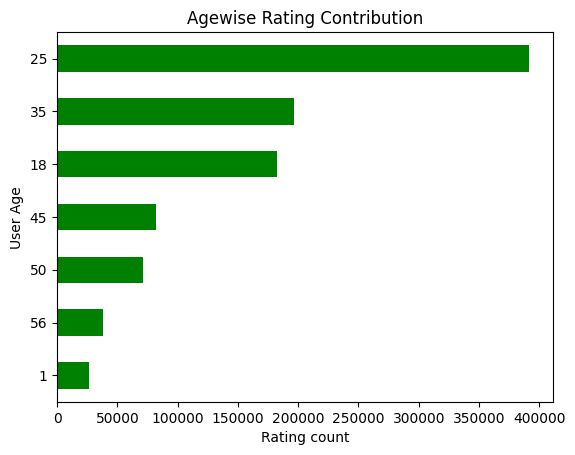

In [225]:
df_zee.groupby('age')['rating'].agg('count').sort_values(ascending = True).plot(kind = 'barh', color = 'g',
                                                                                     title = 'Agewise Rating Contribution', xlabel = 'Rating count',
                                                                                     ylabel = 'User Age')
plt.show()

### 2. Users belonging to which profession have watched and rated the most movies?

In [226]:
occupation_dict = {0: "other",
                   1: "academic/educator",
                   2: "artist",
                   3: "clerical/admin",
                   4: "college/grad student",
                   5: "customer service",
                   6: "doctor/health care",
                   7: "executive/managerial",
                   8: "farmer",
                   9: "homemaker",
                   10: "K-12 student",
                   11: "lawyer",
                   12: "programmer",
                   13: "retired",
                   14: "sales/marketing",
                   15: "scientist",
                   16: "self-employed",
                   17: "technician/engineer",
                   18: "tradesman/craftsman",
                   19: "unemployed",
                   20: "writer"}

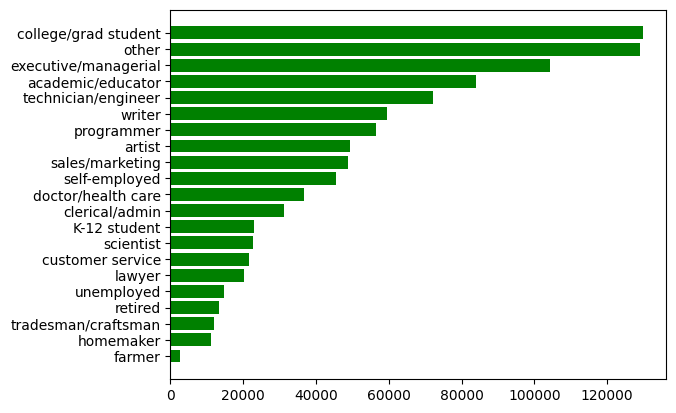

In [227]:
occupation_score = df_zee.groupby('occupation')['rating'].agg('count').sort_values().reset_index()
occupation_score['occupation_title'] = occupation_score['occupation'].map(occupation_dict)
plt.barh(occupation_score['occupation_title'], occupation_score['rating'], color = 'g')
plt.show()

### 3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)

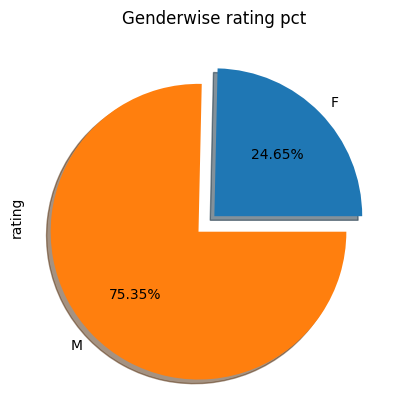

In [228]:
df_zee.groupby('gender')['rating'].agg('count').sort_values(ascending = True).plot(kind = 'pie', title="Genderwise rating pct",
                                                                                   legend=False, autopct='%1.2f%%', explode=(0, 0.15),
                                                                                   shadow=True, startangle=0)
plt.show()

### 4. Most of the movies present in our dataset were released in which decade?
1.   70s
2.   <font color = 'green'><u>90s</u></font>
3.   50s
4.   80s


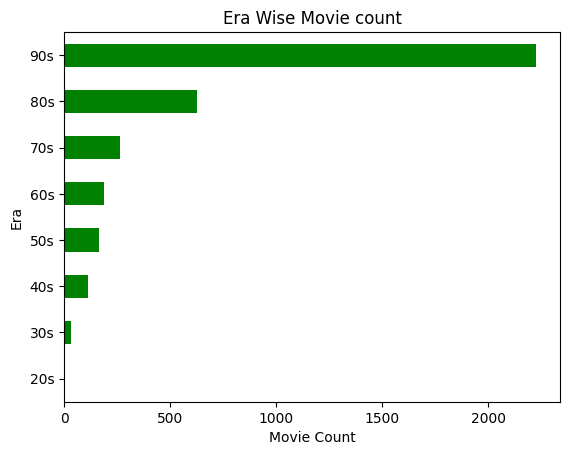

In [229]:
decade_score = df_zee[['movie_id', 'movie_yr']].drop_duplicates()
decade_score.agg({'movie_yr' : [min, max]})
bins = [yr for yr in range(1920, 2010, 10)]
labels = [str(yr)[-2:]+'s' for yr in range(1920, 2010, 10)][:-1]
decade_score['movie_yr_bin'] = pd.cut(decade_score['movie_yr'], bins =  bins, labels = labels)
decade_score.groupby('movie_yr_bin')['movie_id'].count().plot(kind = 'barh', title = 'Era Wise Movie count', ylabel = 'Era', xlabel = 'Movie Count', color= 'g')
plt.show()

### 5. The movie with maximum no. of ratings is ___.

In [230]:
mean_movie_rating = df_zee.groupby('movie_id')['rating'].agg('mean').reset_index()
top_rated_movie_id = mean_movie_rating.loc[mean_movie_rating['rating'] == mean_movie_rating.rating.max()].movie_id.to_list()
print('Top Rated Movies of all time')
movies.loc[movies['movie_id'].isin(top_rated_movie_id)]

Top Rated Movies of all time


,movie_id,title,genres,movie_yr
777,787,"Gate of Heavenly Peace, The (1995)",Documentary,1995
977,989,Schlafes Bruder (Brother of Sleep) (1995),Drama,1995
1762,1830,Follow the Bitch (1998),Comedy,1998
3103,3172,Ulysses (Ulisse) (1954),Adventure,1954
3164,3233,Smashing Time (1967),Comedy,1967
3211,3280,"Baby, The (1973)",Horror,1973
3538,3607,One Little Indian (1973),Comedy|Drama|Western,1973
3587,3656,Lured (1947),Crime,1947
3811,3881,Bittersweet Motel (2000),Documentary,2000


### 6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.

In [231]:
recSys_on_pearson_corr('Liar Liar', rec_cnt=3)

Movie Name: Liar Liar (1997)


,movie_id,title,genres,movie_yr
1422,1447,Gridlock'd (1997),Crime,1997
1497,1534,"Bonheur, Le (1965)",Drama,1965
1619,1665,Bean (1997),Comedy,1997


### 7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.

*  Item - Item Based
*  User - User Based

### 8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.

* Pearson Correlation: -1 to 1
* Cosine Similarity: 0 to 1

### 9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

In [232]:
mf_performance_metric(test_actual, test_pred)

MAE : 1.064174736285973
RMSE : 1.0315884529626982
MAPE : 1.064174736285973


### 10. Give the sparse ‘row’ matrix representation for the following dense matrix -
[[1 0]
[3 7]]

In [233]:
from scipy.sparse import coo_matrix
dense_mat = np.array([[1, 0], [3, 7]])
sparce_mat = coo_matrix(dense_mat)
print(sparce_mat)

  (0, 0)	1
  (1, 0)	3
  (1, 1)	7


In [234]:
sparseMatrix = np.array([[1, 0], [3, 7]])
# initialize size as 0
size = 0

for i in range(2):
    for j in range(2):
        if (sparseMatrix[i][j] != 0):
            size += 1

# number of columns in compactMatrix(size) should
# be equal to number of non-zero elements in sparseMatrix
rows, cols = (3, size)
compactMatrix = [[0 for i in range(cols)] for j in range(rows)]

k = 0
for i in range(2):
    for j in range(2):
        if (sparseMatrix[i][j] != 0):
            compactMatrix[0][k] = i
            compactMatrix[1][k] = j
            compactMatrix[2][k] = sparseMatrix[i][j]
            k += 1

for i, mat in enumerate(compactMatrix):
  if i == 0:
    print('Row Matrix:', mat)
  elif i == 1:
    print('Column Matrix:', mat)
  else:
    print('Value Matrix:', mat)

Row Matrix: [0, 1, 1]
Column Matrix: [0, 0, 1]
Value Matrix: [1, 3, 7]
